In [51]:
from basic_vae_module import VAE
import torch
from torch.utils.data import DataLoader

from dataset import val_set
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np


In [52]:

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

model = VAE.load_from_checkpoint('vae-1.cpkt', map_location=device)


True


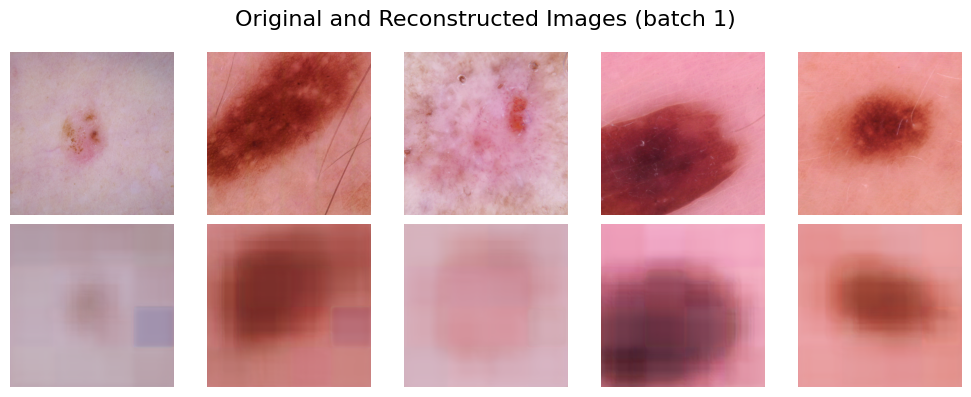

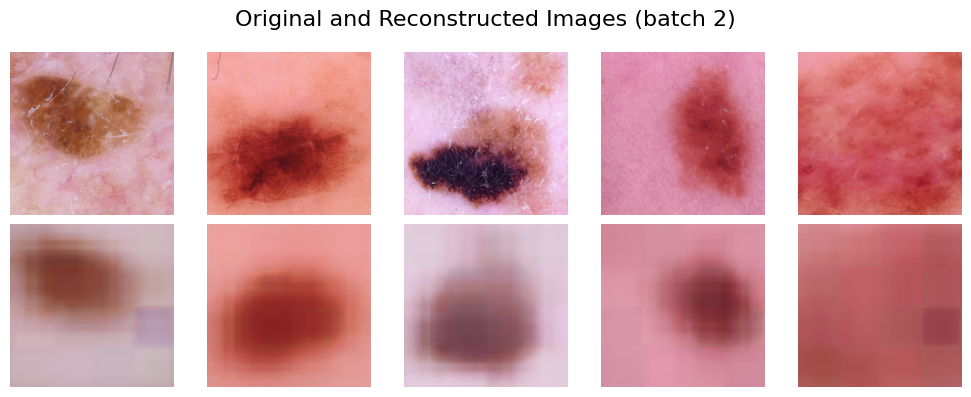

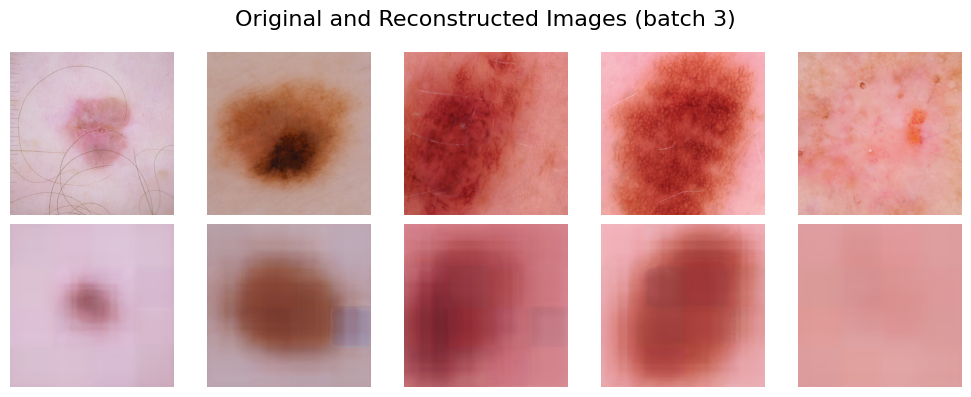

In [57]:
# Visualize some images from the validation set

mean = [194.7155, 139.2602, 145.4779]
std = [36.0167, 38.9894, 43.4381]
val_loader = DataLoader(val_set, batch_size=5, shuffle=False, drop_last=False, num_workers=1)

counter = 1
for batch in val_loader:
    imgs, labels = batch
    imgs = imgs.to(device)
    original_imgs = imgs
    
    recon_imgs = model.forward(imgs)
    
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    
    # add original images
    for i, ax in enumerate(axes[0]):
        image = original_imgs[i]
        image = image.cpu().detach()
        image = image.permute(1, 2, 0)
        image = image.numpy()
        image = image * std + mean
        image = image.astype(np.uint8)
        ax.imshow(image)
        ax.axis('off')

    # add reconstructed images
    for i, ax in enumerate(axes[1]):
        image = recon_imgs[i]
        image = image.cpu().detach()
        image = image.permute(1, 2, 0)
        image = image.numpy()
        image = image * std + mean
        image = image.astype(np.uint8)
        ax.imshow(image)
        ax.axis('off')
        
    plt.suptitle(f"Original and Reconstructed Images (batch {counter})", fontsize=16)
    plt.tight_layout()

    plt.show()

    counter += 1
    if counter >= 4:
        break
        
